# Measurement Errors in Linear Regression
### January 6, 2020

[Brigitta Sipőcz, University of Washington](https://bsipocz.github.io/) 

Resources for this notebook:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 8.
- Paper by [B Kelly, ApJ, 665, 2007](https://iopscience.iop.org/article/10.1086/519947/fulltext/70991.html)
- [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas

We rely on scikit-learn, astroML and pymc3. Full functionality will be available in the next release of astroML (v1.0)

### Lets use simulated data here. 
First we will model the distance of 100 supernovas (for a particular cosmology) as a function of redshift.

We rely on that astroML has a common API with scikit-learn, extending the functionality of the latter.



In [19]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

<ErrorbarContainer object of 3 artists>

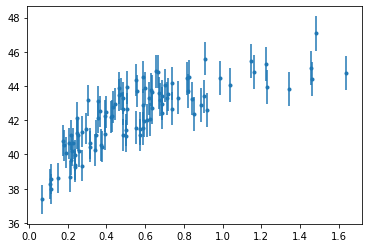

In [2]:
from astropy.cosmology import LambdaCDM
from astroML.datasets import generate_mu_z

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = LambdaCDM(H0=70, Om0=0.30, Ode0=0.70, Tcmb0=0)
z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.')

## Simple linear regression

Regression defined as the relation between a dependent variable, $y$, and a set of independent variables, $x$, 
that describes the expectation value of y given x: $ E[y|x] $

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form
$$
y = ax + b
$$
where $a$ is commonly known as the *slope*, and $b$ is commonly known as the *intercept*.

We can use Scikit-Learn's LinearRegression estimator to fit this data and construct the best-fit line:

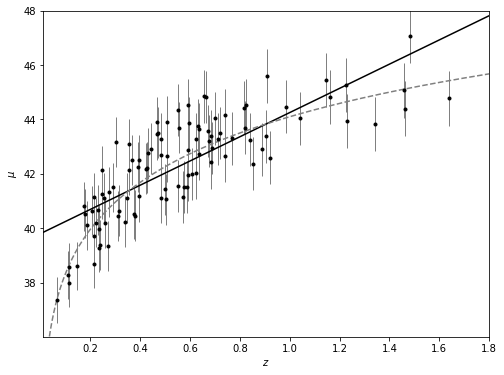

In [3]:
from sklearn.linear_model import LinearRegression as LinearRegression_sk 

linear_sk = LinearRegression_sk()
linear_sk.fit(z_sample[:,None], mu_sample)

mu_fit_sk = linear_sk.predict(z[:, None])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)

ax.plot(z, mu_fit_sk, '-k')
ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(36.01, 48)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

plt.show()

## Measurement errors

Modifications to LinearRegression in astroML take measurement errors into account on the dependent variable.

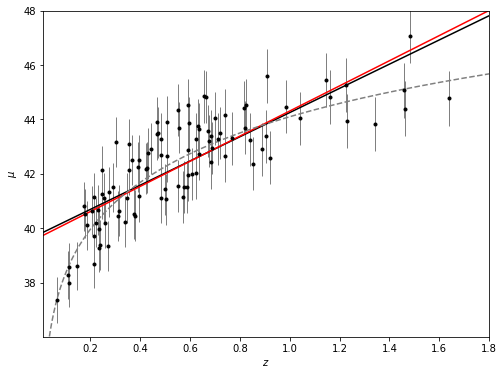

In [4]:
from astroML.linear_model import LinearRegression

linear = LinearRegression()
linear.fit(z_sample[:,None], mu_sample, dmu)

mu_fit = linear.predict(z[:, None])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)

ax.plot(z, mu_fit_sk, '-k')
ax.plot(z, mu_fit, '-k', color='red')

ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(36.01, 48)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

plt.show()

## Basis function regression

If we consider a function in terms of the sum of bases (this can be polynomials, Gaussians, quadratics, cubics) then we can solve for the coefficients using regression. 

### Polynomial basis functions

polynomial regression: $$𝑦=𝑎_0+𝑎_1𝑥+𝑎_2𝑥^2+𝑎_3𝑥^3+⋯$$

Notice that this is still a linear model—the linearity refers to the fact that the coefficients 𝑎𝑛 never multiply or divide each other. What we have effectively done is taken our one-dimensional 𝑥 values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between 𝑥 and 𝑦.

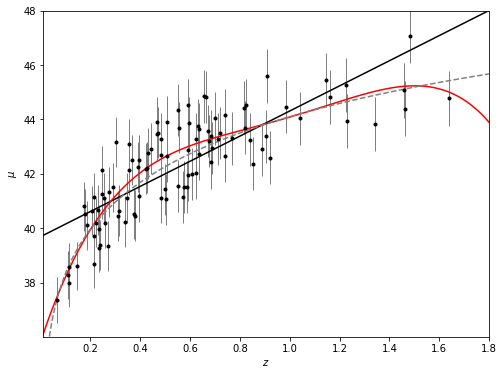

In [46]:
# Use the astroML version to take into account errors on y
from astroML.linear_model import PolynomialRegression

polynomial = PolynomialRegression(degree=4)
polynomial.fit(z_sample[:,None], mu_sample, dmu)

mu_fit_poly = polynomial.predict(z[:, None])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)

ax.plot(z, mu_fit, '-k')
ax.plot(z, mu_fit_poly, '-k', color='red')

ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(36.01, 48)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

plt.show()

### Gaussian basis functions

Of course, other basis functions are possible.
For example, one useful pattern is to fit a model that is not a sum of polynomial bases, but a sum of Gaussian bases. E.g. we could substitute $𝑥^2$ for Gaussians (where we fix $𝜎$ and $𝜇$ and fit for the amplitude) as long as the attribute we are fitting for is linear. This is called basis function regression.


In [47]:
from astroML.linear_model import BasisFunctionRegression




## Measurement errors in both dependent and independent variables

Use simulation data from Kelly 2007


In [37]:
from scipy.stats.distributions import rv_continuous


class simulation_dist(rv_continuous):

    def _pdf(self, x):
        #  eq 110
        return 0.796248 * np.exp(x) / (1 + np.exp(2.75 * x))

    
def simulation(size=50, low=-10, high=10, alpha=1, beta=0.5,
               epsilon=(0, 0.75), scalex=1, scaley=1, multidim=1):
    """
    Data simulator from Kelly 2007
    """
    eps = np.random.normal(epsilon[0], scale=epsilon[1], size=size)
    dist = simulation_dist(a=low, b=high)

    # I'm sorry about ksi, but it's less ambigous than having
    # xi for greek and xi for vector x_i
    ksi = dist.rvs(size=(multidim, size))

    # eq 1
    beta = np.atleast_1d(beta)
    eta = alpha + np.dot(beta, ksi) + eps

    tau = np.var(ksi)

    t = scalex * tau
    s = scaley * epsilon[1]

    # measurement errors from scaled inverse chi2 with df=5
    sigma_x = 5 * t / np.random.chisquare(df=5, size=(multidim, size))
    sigma_y = 5 * s / np.random.chisquare(df=5, size=size)

    x = np.random.normal(ksi, sigma_x)
    y = np.random.normal(eta, sigma_y)

    return ksi, eta, x, y, sigma_x, sigma_y, alpha, beta

ksi, eta, xi, yi, xi_error, yi_error, alpha_in, beta_in = simulation(size=100, scalex=0.3, scaley=0.5, alpha=2)

In [8]:
import pymc3 as pm
from scipy import optimize
from astroML.linear_model import TLS_logL
import theano.tensor as tt

In [9]:
class LinearRegressionwithErrors_MultiVar(LinearRegression):

    def fit(self, X, y, y_error, x_error, sample_kwargs={'draws': 1000, 'target_accept': 0.9}):
         
        with pm.Model() as model:
            # slope and intercept of eta-ksi relation
            slope = pm.Flat('slope', shape=(X.shape[0], ))
            inter = pm.Flat('inter')

            # intrinsic scatter of eta-ksi relation
            int_std = pm.HalfFlat('int_std')
            # standard deviation of Gaussian that ksi are drawn from (assumed mean zero)
            tau = pm.HalfFlat('tau', shape=(X.shape[0],))
            # intrinsic ksi
            mu = pm.Normal('mu', mu=0, sd=tau, shape=(X.shape[0],))
    
            # Some wizzarding with the dimensions all around.
            ksi = pm.Normal('ksi', mu=mu, tau=tau, shape=X.T.shape)

            # intrinsic eta-ksi linear relation + intrinsic scatter
            eta = pm.Normal('eta', mu=(tt.dot(slope.T, ksi.T) + inter), sd=int_std, shape=y.shape)
    
            # observed xi, yi
            x = pm.Normal('xi', mu=ksi.T, sd=x_error, observed=X, shape=X.shape)
            y = pm.Normal('yi', mu=eta, sd=y_error, observed=y, shape=y.shape)
    
            self.trace = pm.sample(**sample_kwargs)
        
        return self

In [38]:
linreg_xy_err = LinearRegressionwithErrors_MultiVar()
linreg_xy_err.fit(xi, yi, yi_error, xi_error)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, ksi, mu, tau, int_std, inter, slope]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1075.84draws/s]


In [29]:
# TLS:
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b


def plot_figure(ksi, eta, x, y, sigma_x, sigma_y, add_regression_lines=False,
                alpha_in=1, beta_in=0.5, basis='linear'):

   # True regression line
    x0 = np.arange(np.min(ksi) - 0.5, np.max(ksi) + 0.5)
    
    # TODO: do properly with .predict()        
    if basis == 'linear':
        y0 = alpha_in + x0 * beta_in
    elif basis == 'poly':
        y0 = alpha_in + beta_in[0] * x0 + beta_in[1] * x0 * x0 + beta_in[2] * x0 * x0 * x0
           
    figure = plt.figure(figsize=(15, 6))

    ax = figure.add_subplot(122)
    ax.scatter(x, y, alpha=0.5)
    ax.errorbar(x, y, xerr=sigma_x, yerr=sigma_y, alpha=0.3, ls='')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
        
    # Redo truth for second panel
    x0 = np.linspace(-10, 10, 40)
    # TODO: do properly with .predict()        
    if basis == 'linear':
        y0 = alpha_in + x0 * beta_in
    elif basis == 'poly':
        y0 = alpha_in + beta_in[0] * x0 + beta_in[1] * x0 * x0 + beta_in[2] * x0 * x0 * x0

    ax.plot(x0, y0, color='black', label='True')
    ax.set_xlim(-12, 12)
    ax.set_ylim(-5, 7)
    #ax.plot([-4, 4, 4, -4, -4], [-3, -3, 3, 3, -3], color='k', alpha=0.5)

    if add_regression_lines:
        x0 = np.arange(-10, 10)
        y0 = np.arange(-4, 6)
        for label, data, *target in [['no err', x, y, 1],
                                     ['y err', x, y, sigma_y],
                                     ['x err', y, x, sigma_x]]:
            linreg = LinearRegression()
            linreg.fit(data[:, None], *target)
            if label == 'x err':
                x_fit = linreg.predict(y0[:, None])
                ax.plot(x_fit, y0, label=label)
            else:
                y_fit = linreg.predict(x0[:, None])
                ax.plot(x0, y_fit, label=label)

        # TLS
        X = np.vstack((x, y)).T
        dX = np.zeros((len(x), 2, 2))
        dX[:, 0, 0] = sigma_x
        dX[:, 1, 1] = sigma_y

        min_func = lambda beta: -TLS_logL(beta, X, dX)
        beta_fit = optimize.fmin(min_func, x0=[-1, 1])
        m_fit, b_fit = get_m_b(beta_fit)
        x_fit = np.linspace(-10, 10, 20)

        ax.plot(x_fit, m_fit * x_fit + b_fit, label='TLS')

    ax.legend()
    
    
def plot_trace(traces, observed, ax=None, chains=None, multidim_ind=None, basis='linear'):

    xi, yi, sigx, sigy = observed

    if multidim_ind is not None:
        xi = xi[multidim_ind]

    if ax is None:
        fig = plt.figure(figsize=(15, 6))

        fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                            bottom=0.1, top=0.95, hspace=0.2)

        # first axes: plot the data
        ax = fig.add_subplot(121)
        ax.errorbar(xi, yi, sigy, sigx, fmt='.k', ecolor='gray', lw=1)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_xlim(-12, 12)
        ax.set_ylim(-5, 7)

    # ------------------------------------------------------------
    # Go through models; compute and plot likelihoods
    linestyles = [':', '--', '-']

    x = np.linspace(np.min(xi)-0.5, np.max(xi)+0.5, 50)

    for i, trace in enumerate(traces):
        if 'theta' in trace.varnames and 'slope' not in trace.varnames:
            trace.add_values({'slope': np.tan(trace['theta'])})

        if multidim_ind is not None:
            trace_slope = trace['slope'][:, multidim_ind]
        else:
            trace_slope = trace['slope']

        if chains is not None:
            for chain in range(100, len(trace) * trace.nchains, chains):
                # TODO: fixme to be less hard wired
                if basis == 'linear':
                    y = trace['inter'][chain] + trace_slope[chain] * x
                elif basis == 'poly':
                    y = trace['inter'][chain] + trace['b1'][chain] * x + trace['b2'][chain] * x * x + trace['b3'][chain] * x * x * x
                ax.plot(x, y, alpha=0.03, c='red')

        # plot the best-fit line only
        if basis == 'linear':
            H2D, bins1, bins2 = np.histogram2d(trace_slope,
                                               trace['inter'], bins=50)

            w = np.where(H2D == H2D.max())

            # choose the maximum posterior slope and intercept
            slope_best = bins1[w[0][0]]
            intercept_best = bins2[w[1][0]]

            print("beta:", slope_best, "alpha:", intercept_best)
            y = intercept_best + slope_best * x
        elif basis == 'poly':
            means = pm.stats.summary(trace)['mean']
            print(means[['inter', 'b1', 'b2', 'b3']])
            y = means['inter'] + means['b1'] * x + means['b2'] * x * x + means['b3'] * x * x * x
        ax.plot(x, y, linestyles[i], label='pymc')
        
        ax.legend()
        break

beta: 0.43397273098008315 alpha: 2.043612617093376


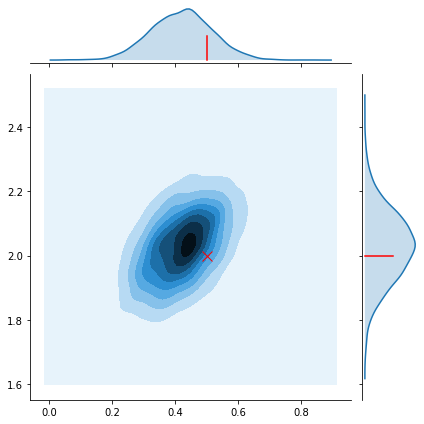

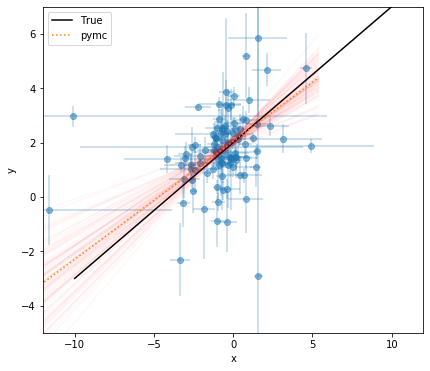

In [39]:
for i in range(len(beta_in)):

    joinpl = sns.jointplot(linreg_xy_err.trace['slope'][:, i], linreg_xy_err.trace['inter'], kind='kde')
    joinpl.ax_joint.plot(beta_in[i], alpha_in, 'x', color='red', ms=10)
    joinpl.ax_marg_y.plot([0, 2], [alpha_in, alpha_in], color='red')
    joinpl.ax_marg_x.plot([beta_in[i], beta_in[i]], [0, 2], color='red')
    
    plot_figure(ksi[i], eta, xi[i], yi, xi_error[i], yi_error, add_regression_lines=False, alpha_in=alpha_in, beta_in=beta_in[i])
    plot_trace([linreg_xy_err.trace,], (xi, yi, xi_error, yi_error), ax=plt.gca(), chains=50, multidim_ind=i)


## Multivariate regression
For multivariate data (where we fit a hyperplane rather than a straight line) we simply extend the description of the regression function to multiple dimensions, with $y = f(x|θ)$ given by
$$ yi =θ_0 +θ_1xi_1 +θ_2xi_2 +···+θ_kxi_k +εi $$